In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from nbformat import read
from csv import DictReader
import os
import shap
import warnings
warnings.filterwarnings('ignore')    

2025-04-21 23:34:59.415830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load datasets
creditcard = pd.read_csv('/Users/devindavis/Applications/CAP5619/frauddetection/creditcard.csv')  # low class ratio
loan_train = pd.read_csv('/Users/devindavis/Applications/CAP5619/frauddetection/loan_train.csv')  # heavily imbalanced  

In [3]:
print("Credit card columns:", creditcard.columns.tolist())
print("Loan train columns:", loan_train.columns.tolist())

Credit card columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Loan train columns: ['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_

In [4]:
# Preprocessing function for loan dataset (with potential non-numeric columns)
def preprocess_loan(df, target='LOAN_DEFAULT'):
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Keep only numeric columns
    X = X.select_dtypes(include=['number'])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Preprocessing function for credit card dataset (assumed to be all numeric)
def preprocess_creditcard(df, target='Class'):
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

# Call both preprocessing functions
X_train_loan, X_test_loan, y_train_loan, y_test_loan = preprocess_loan(loan_train)
X_train_cc, X_test_cc, y_train_cc, y_test_cc = preprocess_creditcard(creditcard)   

In [5]:
from collections import Counter

# Resampling function

def resample_data(X, y, method='over'):
    if method == 'over':
        sampler = RandomOverSampler()
    elif method == 'under':
        sampler = RandomUnderSampler()
    else:
        raise ValueError("Choose 'over' or 'under'")
    X_res, y_res = sampler.fit_resample(X, y)
    return X_res, y_res

X_train_cc_res, y_train_cc_res = resample_data(X_train_cc, y_train_cc, method='over')
X_train_loan_res, y_train_loan_res = resample_data(X_train_loan, y_train_loan, method='under') 

# Print class distributions before and after
print("Credit Card Dataset:")
print("Before oversampling:", Counter(y_train_cc))
print("After oversampling:", Counter(y_train_cc_res))
print("\nLoan Dataset:")
print("Before undersampling:", Counter(y_train_loan))
print("After undersampling:", Counter(y_train_loan_res))

Credit Card Dataset:
Before oversampling: Counter({0: 227451, 1: 394})
After oversampling: Counter({0: 227451, 1: 227451})

Loan Dataset:
Before undersampling: Counter({0: 146034, 1: 40489})
After undersampling: Counter({0: 40489, 1: 40489})


In [6]:
# Build and train model

def build_model(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_evaluate_model(X_train, y_train, X_test, y_test):
    model = build_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)
    preds = model.predict(X_test).flatten()
    preds_binary = (preds > 0.5).astype(int)
    print(classification_report(y_test, preds_binary))
    print("AUC Score:", roc_auc_score(y_test, preds))
    return model  

In [7]:
# Train and evaluate both models

print("===== Credit Card Fraud Detection =====")
model_cc = train_evaluate_model(X_train_cc_res, y_train_cc_res, X_test_cc, y_test_cc)

print("\n===== Loan Default Prediction =====")
model_loan = train_evaluate_model(X_train_loan_res, y_train_loan_res, X_test_loan, y_test_loan)   

===== Credit Card Fraud Detection =====
Epoch 1/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9656 - loss: 0.0826
Epoch 2/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9987 - loss: 0.0062
Epoch 3/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9993 - loss: 0.0036
Epoch 4/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9994 - loss: 0.0031
Epoch 5/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9995 - loss: 0.0026
Epoch 6/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9995 - loss: 0.0023
Epoch 7/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9996 - loss: 0.0021
Epoch 8/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 9/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9996 - loss: 0.0015
Epoch 10/10
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9997 - loss: 0.0014
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step
              precision 

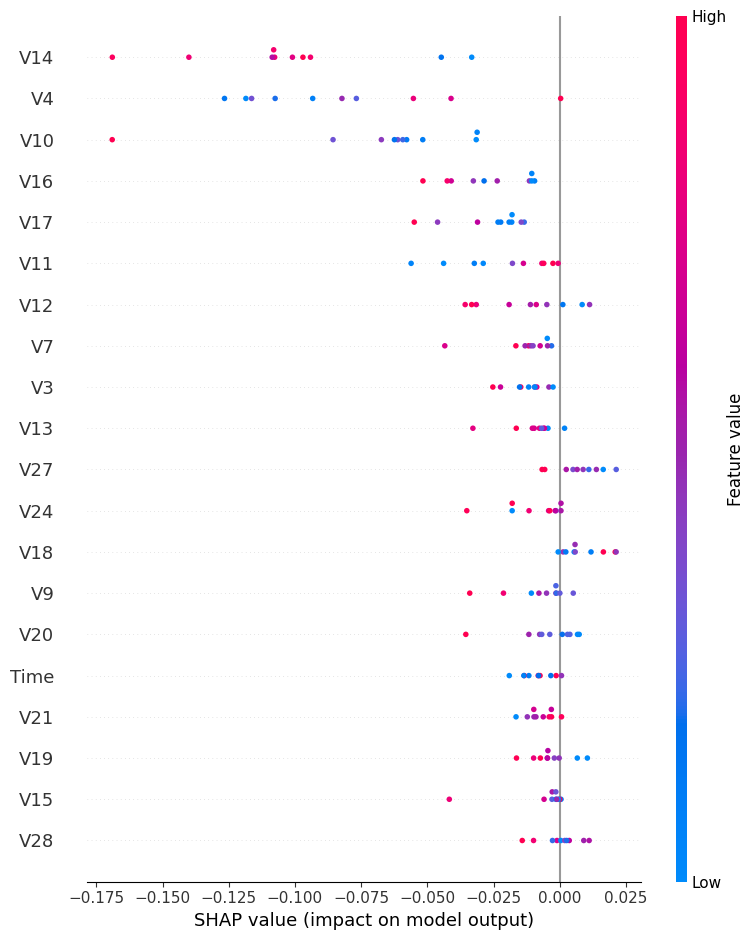

In [8]:
# SHAP Explainability for Credit Card Model

# Use the correct SHAP explainer depending on the model type
explainer = shap.Explainer(model_cc, X_train_cc_res)

# Get SHAP values
shap_values = explainer(X_test_cc[:10])

# Plot summary
shap.summary_plot(shap_values, X_test_cc[:10], feature_names=creditcard.drop(columns='Class').columns)